### 0. Library

In [106]:
import pandas as pd
import re
import unicodedata
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

### 1. Load dataset

In [107]:
df = pd.read_csv('E:/UIT/Năm-2/Kì-2/Predicting-Popularity-of-Vietnamese-Articles/1. Data Collection/dataset1.csv')

In [108]:
# Đổi tên tiêu đề thành tiếng Anh
df= df.rename(columns={
    "Tiêu đề": "title",
    "Ngày đăng": "date",
    "Số từ": "wordcount",
    "Số bình luận": "comments",
    "Tổng tương tác ở bình luận": "interactions",
    "Số ảnh": "images",
    "Số video": "videos",
    "Tags": "tags",
    "Chuyên mục": "category"
})

In [109]:
# Dictionary ánh xạ 'category' thành số
category_mapping = {
    'suc-khoe': 1,
    'the-thao': 2,
    'khoa-hoc': 3,
    'thoi-su': 4,
    'giai-tri': 5,
    'kinh-doanh': 6,
    'cong-nghe': 7,
    'phap-luat': 8,
    'giao-duc': 9
}

# Thay thế giá trị 'Category' bằng số theo dictionary
df['category'] = df['category'].map(category_mapping)

In [110]:
# Kiểm tra thông tin dataframe hiện tại
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5393 entries, 0 to 5392
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         5393 non-null   object
 1   date          5393 non-null   object
 2   wordcount     5393 non-null   int64 
 3   comments      5393 non-null   int64 
 4   interactions  5393 non-null   int64 
 5   images        5393 non-null   int64 
 6   videos        5393 non-null   int64 
 7   tags          4947 non-null   object
 8   category      5393 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 379.3+ KB


### 2. Check missing/duplicated values

In [111]:
# Hàm kiểm tra định dạng ngày giờ: "Chủ nhật, 30/3/2025, 19:00 (GMT+7)"
def is_valid_date(date_str):
    # Biểu thức chính quy cho cả "Chủ nhật" và "Thứ ..."
    pattern = r'^(Chủ nhật|Thứ [a-zA-Zàáãạảăắằẳẵặâấầẩẫậèéẹẻẽêềếểễệìíĩỉịòóõọỏôốồổỗộơớờởỡợùúũụủưứừửữựỳýỹỷỵ]+), \d{1,2}/\d{1,2}/\d{4}, \d{2}:\d{2} \(GMT\+7\)$'

    if pd.isna(date_str):
        return False
    return bool(re.match(pattern, str(date_str)))

# Hàm kiểm tra các lỗi trong DataFrame
def check_dataframe_errors(df):
    errors = []

    # Kiểm tra từng bản ghi
    for index, row in df.iterrows():
        error_messages = []

        # 2. Kiểm tra định dạng ngày giờ
        if not is_valid_date(row['date']):
            error_messages.append(f"Invalid date format: {row['date']}")

        # 3. Kiểm tra các cột số (phải là số nguyên không âm)
        numeric_cols = ['wordcount', 'comments', 'interactions', 'images', 'videos']
        for col in numeric_cols:
            # Kiểm tra giá trị có phải là số không
            if not isinstance(row[col], (int, float)) or pd.isna(row[col]):
                error_messages.append(f"Non-numeric value in column '{col}': {row[col]}")
            # Kiểm tra giá trị âm
            elif row[col] < 0:
                error_messages.append(f"Negative value in column '{col}': {row[col]}")
            # Kiểm tra giá trị bất thường (ví dụ: wordcount = 0 hoặc quá lớn)
            if col == 'wordcount' and row[col] == 0:
                error_messages.append(f"Wordcount is 0, which is unusual")

        # 5. Kiểm tra title và tags không rỗng
        if pd.isna(row['title']) or row['title'].strip() == '':
            error_messages.append("Empty title")
        # Ghi lại lỗi nếu có
        if error_messages:
            errors.append({
                'index': index,
                'title': row['title'],
                'errors': error_messages
            })

    # 6. Kiểm tra bản ghi trùng lặp (dựa trên title)
    duplicated_titles = df[df.duplicated(subset=['title'], keep=False)]
    if not duplicated_titles.empty:
        for index, row in duplicated_titles.iterrows():
            errors.append({
                'index': index,
                'title': row['title'],
                'errors': ['Duplicated title']
            })

    return errors

In [112]:
# Tìm và xuất các bài có tiêu đề trùng lặp
def check_duplicate_titles(df):
    # Đếm số lần xuất hiện của mỗi tiêu đề
    title_counts = df['title'].value_counts()
    # Lấy các tiêu đề trùng lặp (xuất hiện > 1 lần)
    duplicate_titles = title_counts[title_counts > 1].index.tolist()

    duplicates = []
    for title in duplicate_titles:
        # Lấy tất cả các dòng có tiêu đề trùng lặp
        duplicate_rows = df[df['title'] == title]
        for idx, row in duplicate_rows.iterrows():
            duplicates.append((idx, title, row.to_dict()))

    return duplicates

In [113]:
# Chạy kiểm tra
errors = check_dataframe_errors(df)

# In kết quả
if errors:
    print("Found", len(errors), "records with errors:")
    for error in errors:
        print(f"\nIndex: {error['index']}")
        print(f"Title: {error['title']}")
        print("Errors:")
        for msg in error['errors']:
            print(f"  - {msg}")
else:
    print("No errors found in the DataFrame.")

Found 107 records with errors:

Index: 613
Title: Anora' đại thắng Oscar
Errors:
  - Wordcount is 0, which is unusual

Index: 4745
Title: Tiến Linh đoạt Quả Bóng Vàng Việt Nam 2024
Errors:
  - Wordcount is 0, which is unusual

Index: 4875
Title: Việt Nam rung lắc sau động đất hơn 7 độ ở Myanmar
Errors:
  - Wordcount is 0, which is unusual

Index: 43
Title: Sinh viên Việt đoạt giải xuất sắc tại cuộc thi châu Á của Huawei
Errors:
  - Duplicated title

Index: 121
Title: Những cơ chế đặc thù 'cởi trói' cho khoa học công nghệ
Errors:
  - Duplicated title

Index: 158
Title: Thúc đẩy Khoa học công nghệ
Errors:
  - Duplicated title

Index: 185
Title: Thu hút mọi nguồn lực phát triển khoa học công nghệ'
Errors:
  - Duplicated title

Index: 448
Title: Khoa học mà đấu thầu giá rẻ chỉ đem về công nghệ lạc hậu'
Errors:
  - Duplicated title

Index: 556
Title: Bộ Khoa học và Công nghệ công bố 130 quyết định về công tác tổ chức, cán bộ
Errors:
  - Duplicated title

Index: 607
Title: Thủ tướng: Chấp nh

In [114]:
#Bỏ lỗi wordcount = 0
df = df.drop(df[(df['wordcount'] == 0)].index).reset_index(drop=True)
#Bỏ lỗi date format
df= df.drop(df[(df['date'] == 'Không rõ')].index).reset_index(drop=True)
#Bỏ lỗi lặp bài viết có tiêu đề vô nghĩa
df = df.drop(df[(df['title'] == 'Không rõ') |
                 (df['title'] == 'Tinh gọn bộ máy') |
                 (df['title'] == 'Dòng sự kiện') |
                 (df['title'] == 'Tháo gỡ thể chế') |
                 (df['title'] == 'Ảnh') |
                 (df['title'] == 'Đô thị') |
                 (df['title'] == 'Thúc đẩy Khoa học công nghệ') |
                 (df['title'] == 'This site can’t be reached') |
                 (df['title'] == 'Việt Nam 2045')].index).reset_index(drop=True)

In [115]:
df = df[~df['title'].isna() & (df['title'].str.strip() != '')]
duplicates = check_duplicate_titles(df)
#Tạo tạm 1 biến để ưu tiên giữ các bài có cmt và tương tác cao
df['engagement_score'] = df['comments'] + df['interactions']
df = df.sort_values(by='engagement_score', ascending=False)
df = df.drop_duplicates(subset=['title', 'date'], keep='first')
df = df.sort_index()
df = df.drop(columns=['engagement_score'])

In [116]:
# Hiển thị bài viết trùng lặp nhưng được giữ
duplicates = check_duplicate_titles(df)
display(duplicates)

[(5219,
  'Đề xuất bố trí nhà và xe công vụ cho nhà khoa học đầu ngành',
  {'title': 'Đề xuất bố trí nhà và xe công vụ cho nhà khoa học đầu ngành',
   'date': 'Chủ nhật, 16/3/2025, 18:18 (GMT+7)',
   'wordcount': 762,
   'comments': 41,
   'interactions': 793,
   'images': 1,
   'videos': 0,
   'tags': 'phát triển khoa học công nghệ, Luật Khoa học, Công nghệ và Đổi mới sáng tạo',
   'category': 4}),
 (5220,
  'Đề xuất bố trí nhà và xe công vụ cho nhà khoa học đầu ngành',
  {'title': 'Đề xuất bố trí nhà và xe công vụ cho nhà khoa học đầu ngành',
   'date': 'Thứ bảy, 5/4/2025, 00:00 (GMT+7)',
   'wordcount': 1009,
   'comments': 4,
   'interactions': 25,
   'images': 8,
   'videos': 1,
   'tags': 'cầu Trường Tiền, sông Hương, Thành phố Huế, cầu Nguyễn Hoàng',
   'category': 4})]

In [117]:
# Tạo features kiểm tra bài báo có comments và interactions hay không
df['has_comments'] = (df['comments'] > 0).astype(int)
df['has_interactions'] = (df['interactions'] > 0).astype(int)

### 3. Time_since_posted feature calculation

In [118]:
from datetime import datetime

# Mốc thời gian: 12h trưa ngày 18/4/2025
current_time = datetime(2025, 4, 18, 12, 0)

# Tạo bản sao để xử lý
df_copy = df.copy()

# Chuyển đổi cột 'date' trên bản sao
df_copy['date'] = df_copy['date'].str.replace(r' \(GMT\+7\)', '', regex=True)
df_copy['date'] = df_copy['date'].str.replace(r'Chủ nhật, |Thứ bảy, |Thứ hai, |Thứ ba, |Thứ tư, |Thứ năm, |Thứ sáu, ', '', regex=True)
df_copy['date'] = pd.to_datetime(df_copy['date'], format='%d/%m/%Y, %H:%M')

# Tính thời gian kể từ khi đăng bài (bằng giờ)
df_copy['time_since_posted'] = (current_time - df_copy['date']).dt.total_seconds() / 3600
df['time_since_posted'] = df_copy['time_since_posted']

### 4. Xử lí outliers

In [119]:
import numpy as np
from scipy import stats
from scipy.stats import skew

# Danh sách các cột số cần phân tích
numeric_columns = ['wordcount', 'comments', 'interactions', 'images', 'videos',
                   'time_since_posted']

# 1. Phân tích Outlier
def analyze_outliers(df, columns):
    print("\n=== PHÂN TÍCH OUTLIER ===")
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        print(f"\nCột {col}:")
        print(f"Số lượng outlier: {len(outliers)}")
        print(f"Tỷ lệ outlier: {(len(outliers)/len(df))*100:.2f}%")
        print(f"Giá trị min: {df[col].min()}")
        print(f"Giá trị max: {df[col].max()}")
        print(f"Q1: {Q1:.2f}")
        print(f"Q3: {Q3:.2f}")
        print(f"IQR: {IQR:.2f}")
        print(f"Lower bound: {lower_bound:.2f}")
        print(f"Upper bound: {upper_bound:.2f}")

# 2. Phân tích Skewness
def analyze_skewness(df, columns):
    print("\n=== PHÂN TÍCH SKEWNESS ===")
    for col in columns:
        skewness = skew(df[col])
        print(f"\nCột {col}:")
        print(f"Skewness: {skewness:.2f}")
        if abs(skewness) > 1:
            print("Dữ liệu bị lệch đáng kể")
        else:
            print("Dữ liệu tương đối đối xứng")

# 4. Xử lý Outlier
def handle_outliers(df, columns, method='clip'):
    df_cleaned = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        if method == 'clip':
            df_cleaned[col] = df_cleaned[col].clip(lower=lower_bound, upper=upper_bound)
        elif method == 'remove':
            df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) &
                                  (df_cleaned[col] <= upper_bound)]

    return df_cleaned

# 5. Xử lý Skewness
def handle_skewness(df, columns):
    df_transformed = df.copy()
    for col in columns:
        skewness = skew(df[col])
        if abs(skewness) > 1:
            # Thử log transformation
            if df[col].min() > 0:
                df_transformed[col] = np.log1p(df[col])
            # Thử box-cox transformation
            else:
                try:
                    df_transformed[col], _ = stats.boxcox(df[col] + 1)
                except:
                    print(f"Không thể áp dụng box-cox transformation cho cột {col}")

    return df_transformed

# Thực hiện phân tích
print("=== BẮT ĐẦU PHÂN TÍCH ===")
analyze_outliers(df, numeric_columns)
analyze_skewness(df, numeric_columns)

# Xử lý outlier và skewness
df_cleaned = handle_outliers(df, numeric_columns, method='clip')
df_transformed = handle_skewness(df_cleaned, numeric_columns)

# So sánh kết quả sau khi xử lý
print("\n=== KẾT QUẢ SAU KHI XỬ LÝ ===")
analyze_outliers(df_transformed, numeric_columns)
analyze_skewness(df_transformed, numeric_columns)

# Lưu kết quả
df = df_transformed

=== BẮT ĐẦU PHÂN TÍCH ===

=== PHÂN TÍCH OUTLIER ===

Cột wordcount:
Số lượng outlier: 249
Tỷ lệ outlier: 4.69%
Giá trị min: 2
Giá trị max: 3885
Q1: 458.00
Q3: 822.75
IQR: 364.75
Lower bound: -89.12
Upper bound: 1369.88

Cột comments:
Số lượng outlier: 522
Tỷ lệ outlier: 9.83%
Giá trị min: 0
Giá trị max: 857
Q1: 1.00
Q3: 23.00
IQR: 22.00
Lower bound: -32.00
Upper bound: 56.00

Cột interactions:
Số lượng outlier: 626
Tỷ lệ outlier: 11.79%
Giá trị min: 0
Giá trị max: 3474
Q1: 3.00
Q3: 164.75
IQR: 161.75
Lower bound: -239.62
Upper bound: 407.38

Cột images:
Số lượng outlier: 431
Tỷ lệ outlier: 8.12%
Giá trị min: 0
Giá trị max: 18
Q1: 1.00
Q3: 2.00
IQR: 1.00
Lower bound: -0.50
Upper bound: 3.50

Cột videos:
Số lượng outlier: 587
Tỷ lệ outlier: 11.05%
Giá trị min: 0
Giá trị max: 20
Q1: 0.00
Q3: 1.00
IQR: 1.00
Lower bound: -1.50
Upper bound: 2.50

Cột time_since_posted:
Số lượng outlier: 239
Tỷ lệ outlier: 4.50%
Giá trị min: 236.31666666666666
Giá trị max: 7298.083333333333
Q1: 511.00
Q3: 10

In [120]:
import numpy as np
from scipy import stats
from scipy.stats import skew

# Danh sách các cột số cần phân tích
numeric_columns = ['wordcount', 'comments', 'interactions', 'images', 'videos',
                   'time_since_posted']

# 1. Phân tích Outlier
def analyze_outliers(df, columns):
    print("\n=== PHÂN TÍCH OUTLIER ===")
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        print(f"\nCột {col}:")
        print(f"Số lượng outlier: {len(outliers)}")
        print(f"Tỷ lệ outlier: {(len(outliers)/len(df))*100:.2f}%")
        print(f"Giá trị min: {df[col].min()}")
        print(f"Giá trị max: {df[col].max()}")
        print(f"Q1: {Q1:.2f}")
        print(f"Q3: {Q3:.2f}")
        print(f"IQR: {IQR:.2f}")
        print(f"Lower bound: {lower_bound:.2f}")
        print(f"Upper bound: {upper_bound:.2f}")

# 2. Phân tích Skewness
def analyze_skewness(df, columns):
    print("\n=== PHÂN TÍCH SKEWNESS ===")
    for col in columns:
        skewness = skew(df[col])
        print(f"\nCột {col}:")
        print(f"Skewness: {skewness:.2f}")
        if abs(skewness) > 1:
            print("Dữ liệu bị lệch đáng kể")
        else:
            print("Dữ liệu tương đối đối xứng")

# 4. Xử lý Outlier
def handle_outliers(df, columns, method='clip'):
    df_cleaned = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        if method == 'clip':
            df_cleaned[col] = df_cleaned[col].clip(lower=lower_bound, upper=upper_bound)
        elif method == 'remove':
            df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) &
                                  (df_cleaned[col] <= upper_bound)]

    return df_cleaned

# 5. Xử lý Skewness
def handle_skewness(df, columns):
    df_transformed = df.copy()
    for col in columns:
        skewness = skew(df[col])
        if abs(skewness) > 1:
            # Thử log transformation
            if df[col].min() > 0:
                df_transformed[col] = np.log1p(df[col])
            # Thử box-cox transformation
            else:
                try:
                    df_transformed[col], _ = stats.boxcox(df[col] + 1)
                except:
                    print(f"Không thể áp dụng box-cox transformation cho cột {col}")

    return df_transformed

# Thực hiện phân tích
print("=== BẮT ĐẦU PHÂN TÍCH ===")
analyze_outliers(df, numeric_columns)
analyze_skewness(df, numeric_columns)

# Xử lý outlier và skewness
df_cleaned = handle_outliers(df, numeric_columns, method='clip')
df_transformed = handle_skewness(df_cleaned, numeric_columns)

# So sánh kết quả sau khi xử lý
print("\n=== KẾT QUẢ SAU KHI XỬ LÝ ===")
analyze_outliers(df_transformed, numeric_columns)
analyze_skewness(df_transformed, numeric_columns)

# Lưu kết quả
df = df_transformed

=== BẮT ĐẦU PHÂN TÍCH ===

=== PHÂN TÍCH OUTLIER ===

Cột wordcount:
Số lượng outlier: 0
Tỷ lệ outlier: 0.00%
Giá trị min: 2.0
Giá trị max: 1369.875
Q1: 458.00
Q3: 822.75
IQR: 364.75
Lower bound: -89.12
Upper bound: 1369.88

Cột comments:
Số lượng outlier: 0
Tỷ lệ outlier: 0.00%
Giá trị min: 0.0
Giá trị max: 4.224532735474765
Q1: 0.70
Q3: 3.29
IQR: 2.59
Lower bound: -3.19
Upper bound: 7.18

Cột interactions:
Số lượng outlier: 0
Tỷ lệ outlier: 0.00%
Giá trị min: 0.0
Giá trị max: 8.785430745730714
Q1: 1.51
Q3: 7.04
IQR: 5.53
Lower bound: -6.79
Upper bound: 15.33

Cột images:
Số lượng outlier: 0
Tỷ lệ outlier: 0.00%
Giá trị min: 0.0
Giá trị max: 3.5
Q1: 1.00
Q3: 2.00
IQR: 1.00
Lower bound: -0.50
Upper bound: 3.50

Cột videos:
Số lượng outlier: 0
Tỷ lệ outlier: 0.00%
Giá trị min: 0.0
Giá trị max: 0.30638203566876615
Q1: 0.00
Q3: 0.28
IQR: 0.28
Lower bound: -0.42
Upper bound: 0.70

Cột time_since_posted:
Số lượng outlier: 0
Tỷ lệ outlier: 0.00%
Giá trị min: 236.31666666666666
Giá trị max: 1

### 5. Tính target feature

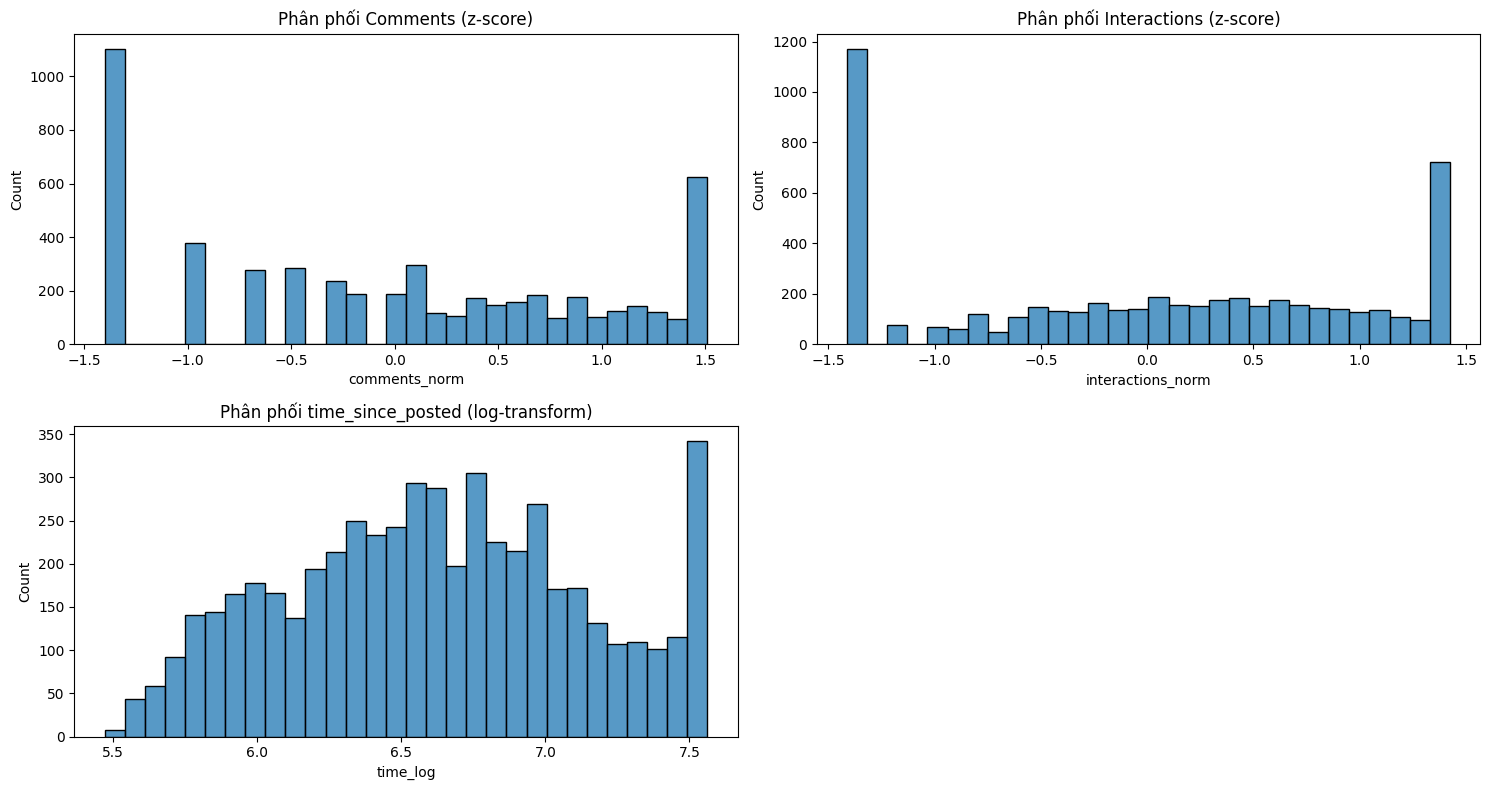

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Copy lại dataframe gốc để tránh ảnh hưởng dữ liệu ban đầu
df_copy = df.copy()

# Nếu đã xử lý outlier/skewness, chỉ cần chuẩn hóa (z-score) các cột comments, interactions
scaler = StandardScaler()
df_copy[['comments_norm', 'interactions_norm']] = scaler.fit_transform(
    df_copy[['comments', 'interactions']]
)

# Log-transform time_since_posted (thêm 1 để tránh log(0))
df_copy['time_log'] = np.log1p(df_copy['time_since_posted'])

# Vẽ histogram để so sánh phân phối
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
sns.histplot(data=df_copy, x='comments_norm', bins=30)
plt.title('Phân phối Comments (z-score)')
plt.subplot(2, 2, 2)
sns.histplot(data=df_copy, x='interactions_norm', bins=30)
plt.title('Phân phối Interactions (z-score)')
plt.subplot(2, 2, 3)
sns.histplot(data=df_copy, x='time_log', bins=30)
plt.title('Phân phối time_since_posted (log-transform)')
plt.tight_layout()
plt.show()

In [124]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Giả sử bạn đã chuẩn hóa comments, interactions (likes), time_log như hướng dẫn trước
comments = df_copy['comments_norm']
likes = df_copy['interactions_norm']
time = df_copy['time_log']  # Đã log-transform, KHÔNG chuẩn hóa z-score
X_combined = df_copy[["comments_norm", "interactions_norm", "time_log"]]  # hoặc các feature khác bạn muốn dùng

# Hàm tính popularity_score
def calculate_popularity_score(comments, likes, time, alpha, beta, min_time_log=1.5):
    denominator = np.maximum(time, min_time_log)
    numerator = alpha * comments + beta * likes
    mask = (comments > 0) | (likes > 0)
    score = np.zeros_like(comments)
    score[mask] = numerator[mask] / denominator[mask]
    return np.maximum(score, 0)

# Hàm đánh giá mô hình
def evaluate_model(X, popularity_score, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, popularity_score, test_size=0.2, random_state=random_state)
    model = Ridge()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

# Loss function cho gradient descent
def loss_function(alpha, beta, comments, likes, time, X):
    popularity_score = calculate_popularity_score(comments, likes, time, alpha, beta)
    return evaluate_model(X, popularity_score)

# Gradient Descent để tinh chỉnh alpha, beta
def gradient_descent(alpha_init, beta_init, comments, likes, time, X, learning_rate=0.01, max_iters=100):
    alpha, beta = alpha_init, beta_init
    for _ in range(max_iters):
        delta = 1e-5
        grad_alpha = (loss_function(alpha + delta, beta, comments, likes, time, X) -
                      loss_function(alpha, beta, comments, likes, time, X)) / delta
        grad_beta = (loss_function(alpha, beta + delta, comments, likes, time, X) -
                     loss_function(alpha, beta, comments, likes, time, X)) / delta
        alpha -= learning_rate * grad_alpha
        beta -= learning_rate * grad_beta
        alpha = np.clip(alpha, 0.1, 2.0)
        beta = np.clip(beta, 0.1, 2.0)
    mse = loss_function(alpha, beta, comments, likes, time, X)
    return alpha, beta, mse

# GridSearch để tìm tổ hợp alpha, beta tốt nhất
alphas = np.linspace(0.1, 2, 20)
betas = np.linspace(0.1, 2, 20)
best_params = []
for a in alphas:
    for b in betas:
        popularity_score = calculate_popularity_score(comments, likes, time, a, b)
        mse = evaluate_model(X_combined, popularity_score)
        best_params.append((a, b, mse))

# Chọn k tổ hợp tốt nhất
k = 5
best_params = sorted(best_params, key=lambda x: x[2])[:k]
print(f"Top {k} tổ hợp từ GridSearch: {best_params}")

# Tinh chỉnh các tổ hợp tốt nhất bằng gradient descent
final_params = []
for a, b, mse in best_params:
    alpha_opt, beta_opt, mse_opt = gradient_descent(a, b, comments, likes, time, X_combined)
    final_params.append((alpha_opt, beta_opt, mse_opt))

# Chọn tổ hợp tốt nhất
best_alpha, best_beta, best_mse = min(final_params, key=lambda x: x[2])
print(f"Best α, β sau Gradient Descent: ({best_alpha:.4f}, {best_beta:.4f}), MSE: {best_mse:.4f}")

Top 5 tổ hợp từ GridSearch: [(np.float64(0.1), np.float64(0.1), 5.8044284594757796e-05), (np.float64(0.1), np.float64(0.2), 0.00013040173740407808), (np.float64(0.2), np.float64(0.1), 0.00013116919863620733), (np.float64(0.2), np.float64(0.2), 0.00023217713837903118), (np.float64(0.1), np.float64(0.3), 0.00023217762527364725)]
Best α, β sau Gradient Descent: (0.1000, 0.1000), MSE: 0.0001

Thống kê popularity_score:
count    5310.000000
mean        0.012840
std         0.016135
min         0.000000
25%         0.000000
50%         0.002066
75%         0.025602
max         0.052807
Name: popularity_score, dtype: float64


In [125]:
df_copy.drop(columns=['comments_norm', 'interactions_norm', 'time_log'], inplace=True, errors='ignore')
# Lưu file đã có popularity_score
df_copy.to_csv('E:/UIT/Năm-2/Kì-2/Predicting-Popularity-of-Vietnamese-Articles/2. Data Pre-processing/dataset2.csv', index=False)